This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [1]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K
from spatial_transformer import SpatialTransformer

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../datasets/mnist_cluttered_60x60_6distortions.npz"

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

'1.2.1'

In [3]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))


input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
('Input shape:', (60, 60, 1))


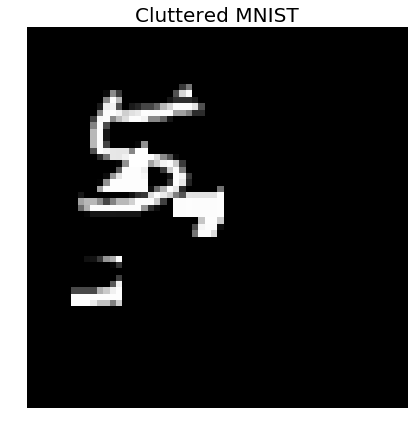

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [5]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [6]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, (5, 5)))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [7]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             output_size=(30,30), input_shape=input_shape))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_1 (Spati (None, 30, 30, 1)         91896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
__________

In [8]:
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

In [9]:
print(X_train.shape[0]/batch_size)

390


----------------------------------------
 9920/10000 [============================>.] - ETA: 0sEpoch: 0 | Valid: 0.9651578125 | Test: 0.965832573318


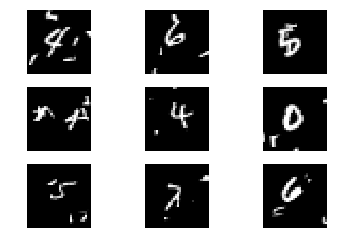

----------------------------------------
 9952/10000 [============================>.] - ETA: 0sEpoch: 1 | Valid: 0.640225034475 | Test: 0.640897003698


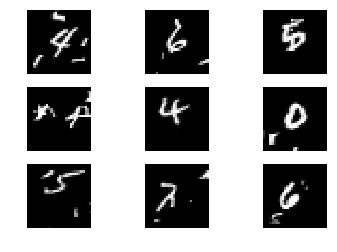

----------------------------------------
 9920/10000 [============================>.] - ETA: 0sEpoch: 2 | Valid: 0.478311386704 | Test: 0.479058407283


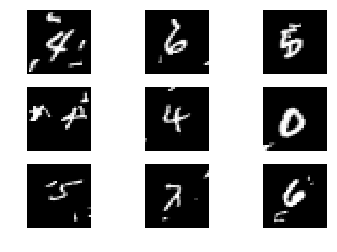

----------------------------------------
 9856/10000 [============================>.] - ETA: 0sEpoch: 3 | Valid: 0.389098614812 | Test: 0.391947608852


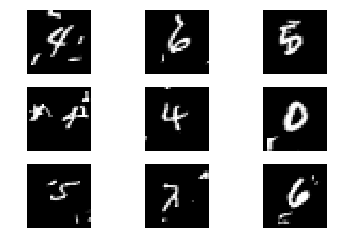

----------------------------------------
 9856/10000 [============================>.] - ETA: 0sEpoch: 4 | Valid: 0.389306117272 | Test: 0.388585087323


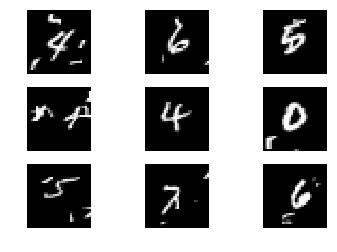

----------------------------------------
 9920/10000 [============================>.] - ETA: 0sEpoch: 5 | Valid: 0.342985617232 | Test: 0.333935720134


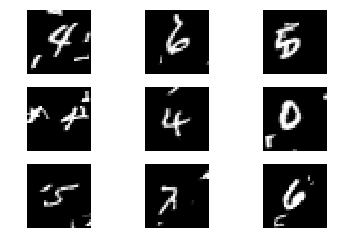

----------------------------------------
 9920/10000 [============================>.] - ETA: 0sEpoch: 6 | Valid: 0.352025858569 | Test: 0.355899694514


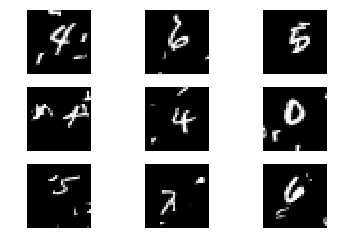

----------------------------------------
 9952/10000 [============================>.] - ETA: 0sEpoch: 7 | Valid: 0.326370839524 | Test: 0.322093390715


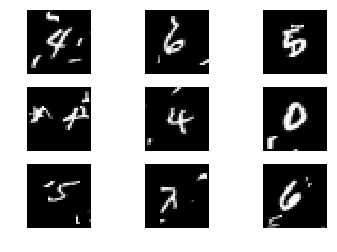

----------------------------------------
 9920/10000 [============================>.] - ETA: 0sEpoch: 8 | Valid: 0.267471118855 | Test: 0.268348127568


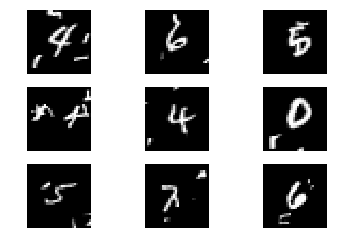

----------------------------------------
 9952/10000 [============================>.] - ETA: 0sEpoch: 9 | Valid: 0.235457563335 | Test: 0.237717633945


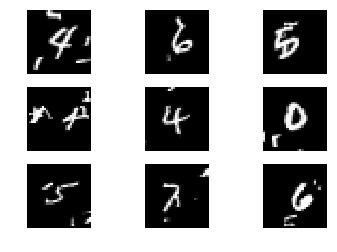

In [10]:
nb_epochs = 10 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            #print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev = model.evaluate(X_valid, y_valid, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            Xresult = F([X_batch[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

### Visualizing what the Spatial Transformer learned

In [11]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

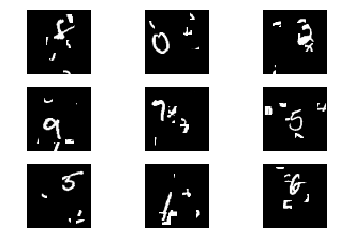

In [12]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

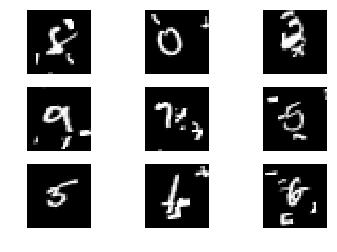

In [13]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

In [14]:
model.save_weights('weights.h5')